In [1]:
import socket
from multiprocessing.dummy import Process
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np

In [2]:
HOST = '127.0.0.1'
FAKE_PORT = 65003
REAL_PORT = 65004

In [3]:
class ImageNetworker(Process):
    """
    Contains utilities for sending/receiving images using sockets.
    """
    def __init__(self, block_size=1024, name='networker'):
        super().__init__()
        self.block_size = block_size
        self.name = name
    
    def log(self, *args):
        print(f'{self.name} /', *args)
        
    # --- SENDING
    def send_image(self, image, socket):
        n_bytes = self.send_image_meta(image, socket)
        n_iters = n_bytes // self.block_size
        n_remains = n_bytes - n_iters * self.block_size
        im_bytes = image.tobytes()
        for i in range(n_iters):
            block = im_bytes[self.block_size * i: (i+1) * self.block_size]
            assert socket.sendall(block) is None, f'Could not send image byte block i={i}'
        
        if n_remains > 0:
            block = im_bytes[-n_remains:]
            assert socket.sendall(block) is None, f'Could not send remaining byte block'
        
        self.log('Image is sent.')
        
    def send_image_meta(self, image, socket):
        h, w, _ = image.shape
        n_bytes = h * w * 3  # 3 channels
        bytes_array = image.tobytes()
        
        # --- Send image meta info
        # 1. N_Bytes
        assert self.send_int(n_bytes, socket) is None, 'Could not send n_bytes'
        # 2. height
        assert self.send_int(h, socket) is None, 'Could not send height'
        # 3. width
        assert self.send_int(w, socket) is None, 'Could not send width'
        return n_bytes
    
    def send_int(self, number, socket):
        _bytes = number.to_bytes(length=4, byteorder='big')
        return socket.sendall(_bytes)
    
    # --- RECEIVING
    
    def recv_image(self, conn):
        n_bytes, h, w = self.recv_image_meta(conn)
        n_iters = n_bytes // self.block_size
        n_remains = n_bytes - n_iters * self.block_size
        im_bytes = []
        n_received = 0
        while True:
            block = conn.recv(self.block_size)
            im_bytes.append(block)
            n_received += len(block)
            
            if n_received == n_bytes:
                break
        
        if n_remains > 0:
            block = conn.recv(n_remains)
            im_bytes.append(block)
            
        im_bytes = b''.join(im_bytes)
        image = np.frombuffer(im_bytes, dtype='uint8')
        image = image.reshape(h, w, 3)
        #self.assert_success()
        print(f'Received image with size={h, w}.')
        return image
            
    def recv_image_meta(self, conn):
        # --- Recv image meta info
        # 1. N_Bytes
        n_bytes = self.recv_int(conn)
        # 2. height
        h = self.recv_int(conn)
        # 3. width
        w = self.recv_int(conn)
        return n_bytes, h, w
    
    def recv_int(self, conn):
        _bytes = conn.recv(4)
        return int.from_bytes(_bytes, byteorder='big')

In [4]:
class Client(ImageNetworker):
    def __init__(self, server_port, image, block_size=1024):
        super().__init__(block_size, 'Client')
        self.port = server_port
        self.image = image
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    
    def run(self):
        with self.socket as s:
            self.log(f'Connecting to server with port {self.port}')
            s.connect((HOST, self.port))
            self.log('Connected. Sending image.')
            self.send_image(self.image, self.socket)

In [5]:
class Server(ImageNetworker):
    def __init__(self, server_port, block_size=1024, recv_noise=True, use_denoising=True):
        super().__init__(block_size, 'Server')
        self.port = server_port
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.socket.bind((HOST, server_port))
        self.socket.listen()
        self.recv_noise = recv_noise
        self.use_denoising = use_denoising
    
    def run(self):
        with self.socket as s:
            self.log(f'Accepting {self.port}')
            conn, addr = s.accept()
            self.log('Connected. Receiving image.')
            self.image = self.recv_image(conn)
            # Make a placeholder for noise image in case it was not received
            self.noise_image = self.image
            if self.recv_noise:
                self.noise_image = self.recv_image(conn)
                
        self.denoised_image = self.noise_image
        if self.use_denoising:
            self.denoised_image = self.denoise(self.noise_image)

        self.log('Testing on denoised image')
        self.perform_test(self.denoised_image)
        self.log('Testing on noise image')
        self.perform_test(self.noise_image)
    
    def perform_test(self, noise_image):
        diff = (np.abs(self.image - noise_image) < 20).mean()
        self.log('Percentage of unaffected pixels:', diff)
        diff = np.abs(self.image - noise_image).astype('float32').mean()
        self.log('Mean absolute difference:', diff)
        diff = np.square((self.image - noise_image).astype('float32')).mean()
        self.log('Square difference:', diff)

    def denoise(self, im):
        return cv2.medianBlur(im, ksize=5)

In [6]:
from random import random

class NoiseServer(ImageNetworker):
    def __init__(self, fake_server_port, real_server_port, block_size=1024):
        super().__init__(block_size, 'NoiseServer')
        # Receives image from the client
        self.recv_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.recv_socket.bind((HOST, fake_server_port))
        self.recv_socket.listen()
        self.fake_server_port = fake_server_port
        
        # Sends image to the server
        self.send_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.real_server_port = real_server_port
        
    def run(self):
        with self.recv_socket as s:
            self.log(f'Accepting {self.fake_server_port}')
            conn, addr = s.accept()
            self.log('Connected. Sending image.')
            image = self.recv_image(conn)
        
        noise_image = self.add_noise(image)
        with self.send_socket as s:
            s.connect((HOST, self.real_server_port))
            self.send_image(image, s)
            self.send_image(noise_image, s)
        
    def add_noise(self, im):
        im = im.copy()
        h, w, _ = im.shape
        for y in range(h):
            for x in range(w):
                if random() > 0.9:
                    im[y, x] = int(random() > 0.5) * 255
        return im

In [7]:
im = cv2.imread('img.jpg')

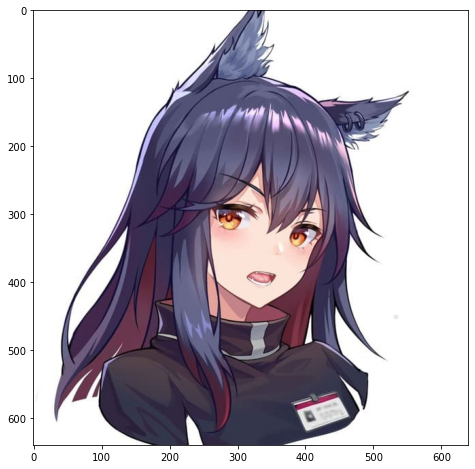

In [8]:
plt.figure(figsize=(8, 8))
plt.imshow(im[...,::-1])

In [9]:
server = Server(REAL_PORT, use_denoising=True)

server.start()

Server / Accepting 65004


In [10]:
noise_server = NoiseServer(FAKE_PORT, REAL_PORT)
noise_server.start()

NoiseServer / Accepting 65003


In [11]:
client = Client(FAKE_PORT, im)

client.start()

Client / Connecting to server with port 65003
Client / Connected. Sending image.
NoiseServer / Connected. Sending image.
Client /Received image with size=(640, 640). Image is sent.

Server / Connected. Receiving image.
NoiseServer /Received image with size=(640, 640). Image is sent.

Received image with size=(640, 640).NoiseServer /
 Image is sent.
Server / Testing on denoised image
Server / Percentage of unaffected pixels: 0.8073600260416667
Server / Mean absolute difference: 44.52179
Server / Square difference: 10649.501
Server / Testing on noise image
Server / Percentage of unaffected pixels: 0.9251114908854167
Server / Mean absolute difference: 11.6912985
Server / Square difference: 2391.7554


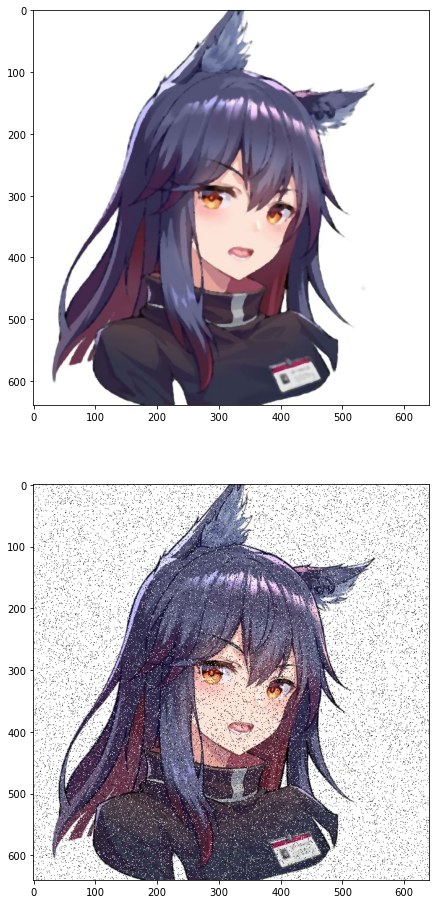

In [12]:
plt.figure(figsize=(32, 16))
plt.subplot(2, 1, 1)
plt.imshow(server.denoised_image[..., ::-1])
plt.subplot(2, 1, 2)
plt.imshow(server.noise_image[..., ::-1])